In [100]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression, Ridge

In [101]:
figsize = (16, 8)
legend_fontsize = 16

In [102]:
# Constants
START_DATE = datetime(2020, 3, 3)
MAY_FIRST = (datetime(2020, 5, 1) - START_DATE).days
JUNE_FIRST = (datetime(2020, 6, 1) - START_DATE).days
SEPTEMBER_FIRST = (datetime(2020, 9, 1) - START_DATE).days

In [103]:
# Download dataset
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.csv

In [104]:
# Read dataset
data = pd.read_csv("/content/owid-covid-data.csv")

In [105]:
# Converting date column into daterime format
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

In [106]:
data_after_START = data[data['date'] >= START_DATE]

In [107]:
data = data[["date", "location", "total_cases", "new_cases"]]

In [108]:
data_rus = data_after_START[data_after_START['location'] == 'Russia']

In [109]:
data_rus.loc[data_rus['new_cases'] == 0, 'new_cases'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [110]:
data_rus["day"] = (data_rus["date"] - datetime(2020,3,3)).dt.days

data_rus = data_rus.astype({"new_cases": int, "total_cases": int})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
rus_train = data_rus.iloc[:50]
rus_test = data_rus.iloc[50:]

In [112]:
# 2

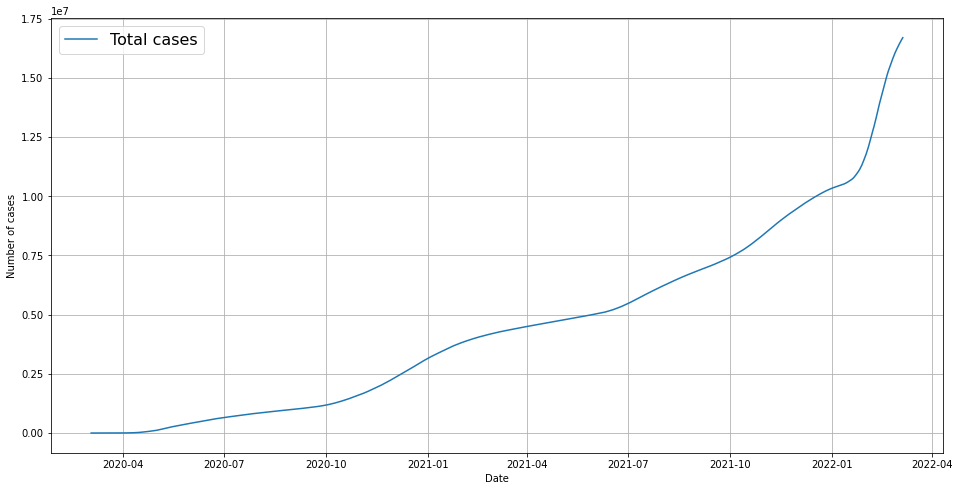

In [113]:
plt.figure(figsize=figsize)
plt.plot(data_rus["date"], data_rus["total_cases"], label="Total cases")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.legend(fontsize=legend_fontsize)

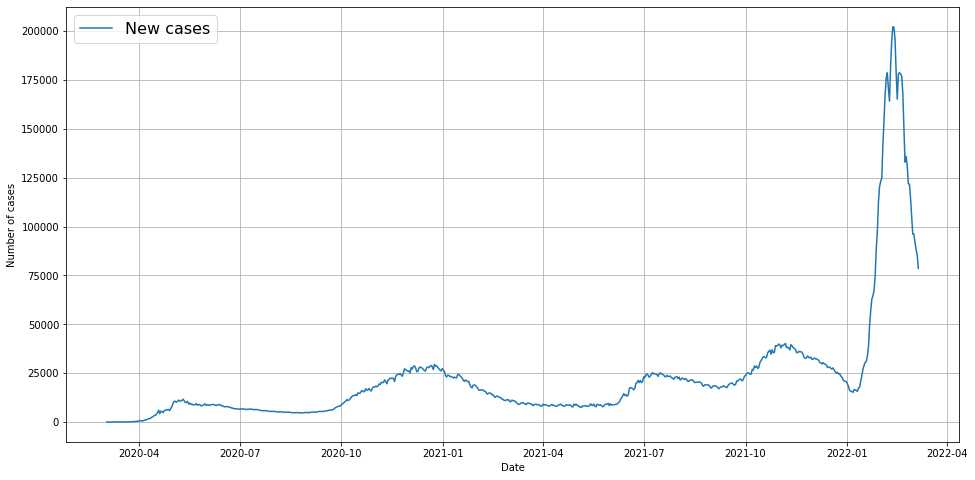

In [114]:
plt.figure(figsize=figsize)
plt.plot(data_rus["date"], data_rus["new_cases"], label="New cases")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.legend(fontsize=legend_fontsize)

In [115]:
# 2 a

In [116]:
model = LinearRegression()

In [117]:
model.fit(rus_train['day'].values.reshape(-1, 1), np.log(rus_train['total_cases']))

LinearRegression()

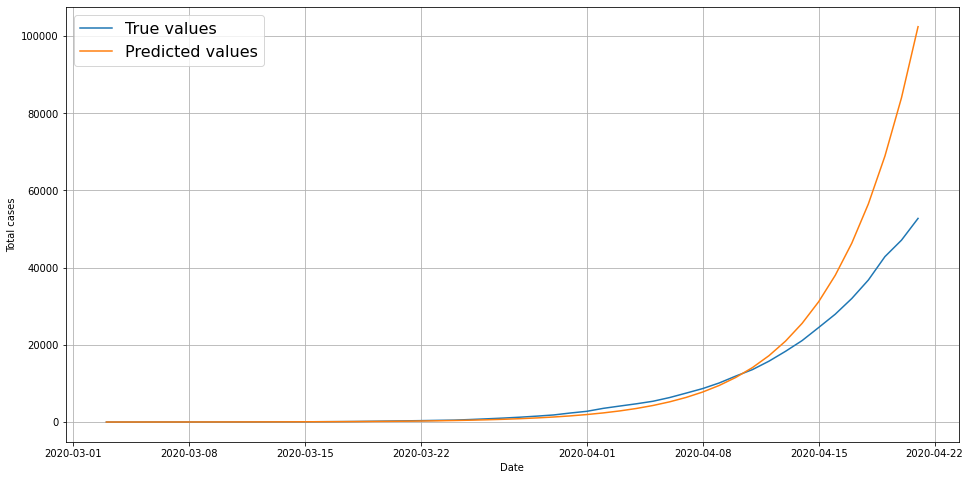

In [118]:
prediction = model.predict(rus_train["day"].values.reshape(-1, 1))

plt.figure(figsize=figsize)
plt.plot(
    rus_train["date"],
    rus_train["total_cases"],
    label="True values"
)
plt.plot(
    rus_train["date"],
    np.exp(prediction),
    label="Predicted values"
)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize)

In [119]:
# 2 b

In [120]:
sigma_noise = np.mean((np.log(rus_train["total_cases"]) - prediction) ** 2)

In [121]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) *
                            np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n,
                     np.matmul(np.linalg.inv(sigma), np.transpose(mu)) +
                     (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [122]:
x = np.column_stack([np.ones(rus_train.shape[0]), rus_train["day"]])

mu, sigma = bayesian_update(np.zeros(2),
                            1000 * np.eye(2),
                            x,
                            np.log(rus_train["total_cases"]).values,
                            sigma_noise)

In [123]:
print(f"W mean:\n{mu}")
print(f"W variance:\n{sigma}")

W mean:
[1.82073506 0.19829098]
W variance:
[[ 1.15248767e-03 -3.49238688e-05]
 [-3.49238688e-05  1.42546446e-06]]


In [124]:
# 2 c

In [125]:
n = 1000
w = np.random.multivariate_normal(mu, sigma, n)

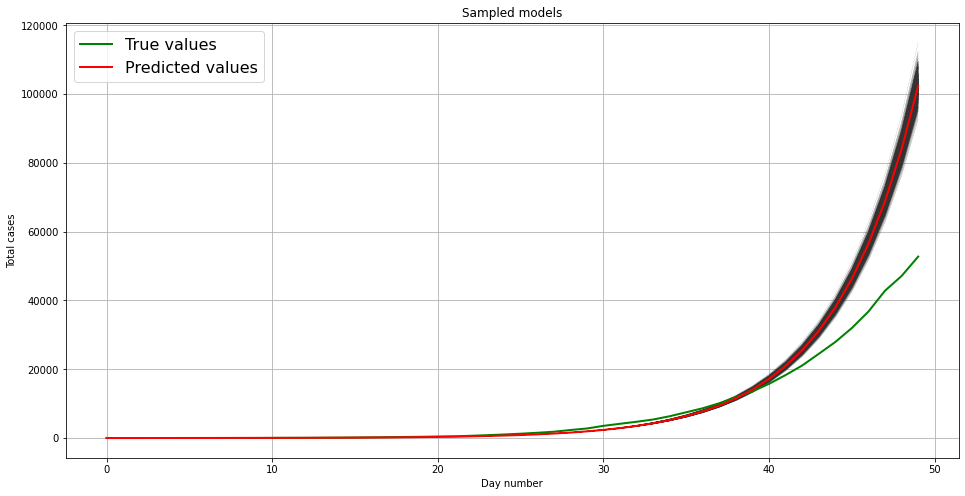

In [126]:
plt.figure(figsize=figsize)
plt.title("Sampled models")
# Sampled exponents:
for i in range(n):
    plt.plot(rus_train["day"], np.exp(x.dot(w[i])),
             color="0.2", linewidth=.1)
# True values:
plt.plot(rus_train["day"], rus_train["total_cases"],
         label="True values", color="g", linewidth=2)
# Predicted values:
plt.plot(rus_train["day"], np.exp(prediction),
         label="Predicted values", color="r", linewidth=2)
plt.grid(True)
plt.xlabel("Day number")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize)

In [127]:
x = pd.Series([MAY_FIRST, JUNE_FIRST, SEPTEMBER_FIRST])

x_matrix = np.column_stack([np.ones(len(x)), x])

prediction = np.exp(w.dot(x_matrix.T))

Text(0.5, 1.0, 'May 1 prediction distribution')

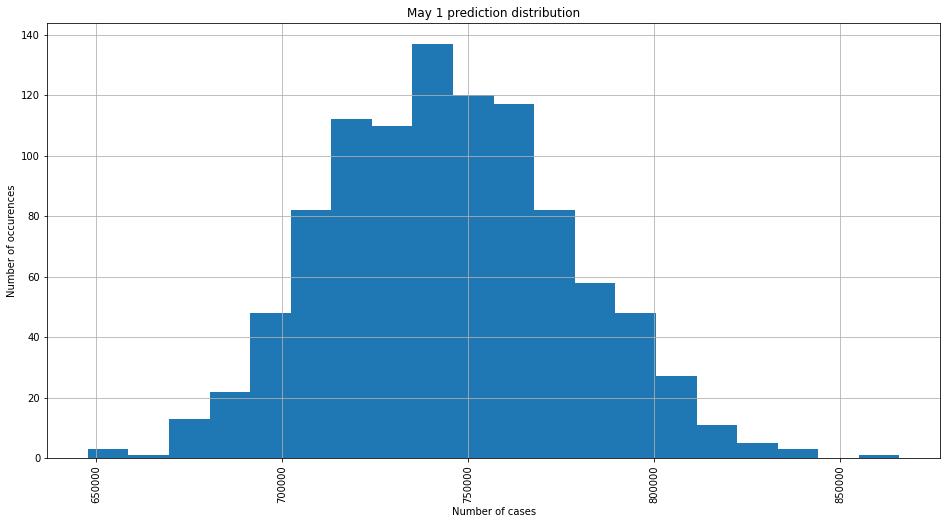

In [128]:
plt.figure(figsize=figsize)
plt.hist(prediction[:, 0], bins=20)
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("May 1 prediction distribution")

In [129]:
# Prediction for May 1
print(f"Median:\t\t{round(np.quantile(prediction[:, 0], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(prediction[:, 0], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(prediction[:, 0], 0.9))}")
print(f"True value:\t" \
      f"{rus_test[rus_test['day'] == MAY_FIRST]['total_cases'].iloc[0]}")

Median:		743088
10-quantile:	705067
90-quantile:	788203
True value:	114431


Text(0.5, 1.0, 'June 1 prediction distribution')

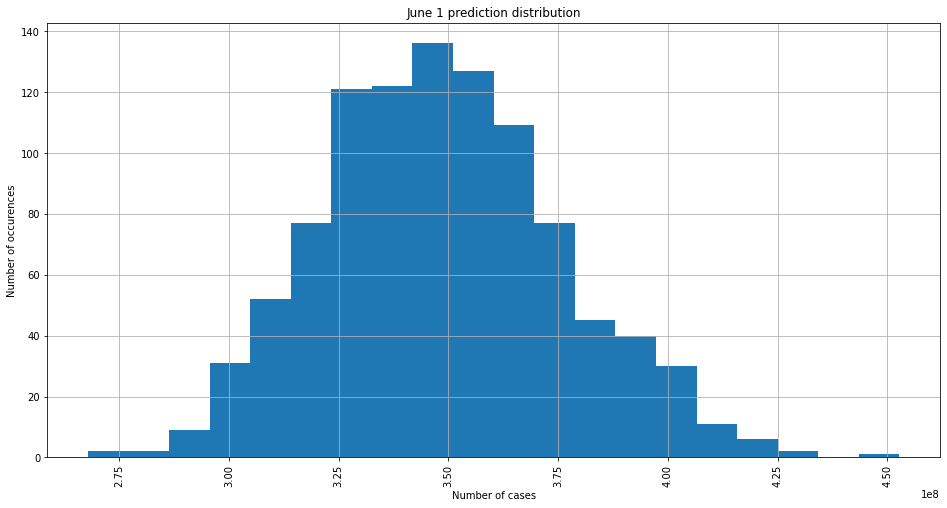

In [130]:
plt.figure(figsize=figsize)
plt.hist(prediction[:, 1], bins=20)
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("June 1 prediction distribution")

In [131]:
# Prediction for June 1
print(f"Median:\t\t{round(np.quantile(prediction[:, 1], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(prediction[:, 1], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(prediction[:, 1], 0.9))}")
print(f"True value:\t" \
      f"{rus_test[rus_test['day'] == JUNE_FIRST]['total_cases'].iloc[0]}")

Median:		347151700
10-quantile:	314907046
90-quantile:	384024411
True value:	414328


Text(0.5, 1.0, 'September 1 prediction distribution')

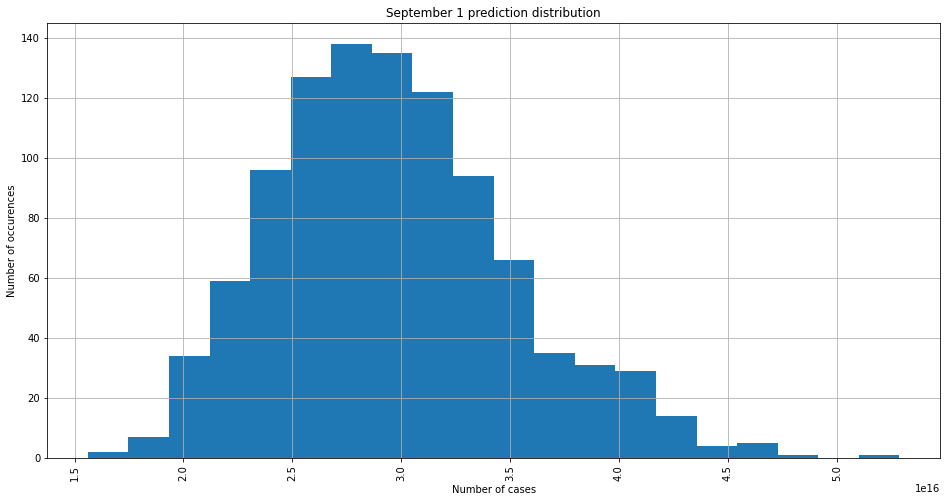

In [132]:
plt.figure(figsize=figsize)
plt.hist(prediction[:, 2], bins=20)
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("September 1 prediction distribution")

In [133]:
# Prediction for September 1
print(f"Median:\t\t{round(np.quantile(prediction[:, 2], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(prediction[:, 2], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(prediction[:, 2], 0.9))}")
print(f"True value:\t" \
      f"{rus_test[rus_test['day'] == SEPTEMBER_FIRST]['total_cases'].iloc[0]}")

Median:		29066569255284304
10-quantile:	23035447757123752
90-quantile:	36799355440459896
True value:	997072


In [134]:
# 2.3 a

Представим произвольную квадратичную функцию в экспоненте под интегралом в виде многочлена второй степени:

$at^2 + bt + c$

Тогда уравнение сигмоиды можно представить в виде:

$y(x) = k \int^x_{-\infty}{e^{at^2 + bt + c}}dt = \int^x_{-\infty}{e^{logk(at^2 + bt + c)}}dt = \int^x_{-\infty}{e^{at^2 + bt + c'}}dt$

Диапазон номеров дней для расчёта предсказаний начинается не на минус бесконечности, а в нуле, и имеет дискретный вид. С учётом этого, а также прологарифмировав обе части выражения, получим:

$log(y_i - y_{i-1}) = at^2 + bt + c'$

Таким образом, для обучения модели в качестве признаков будем использовать номер дня и его квадрат, а в качестве целевой переменной — логарифм разности текущего и предыдущего значений целевой переменной (для total_cases разностью текущего и предыдущего значений будет new_cases).

In [135]:
# 2.3b

In [136]:
model = LinearRegression()
x = np.column_stack([rus_train["day"], rus_train["day"] ** 2])
y = np.log(rus_train["new_cases"].values)
model.fit(x, y)

LinearRegression()

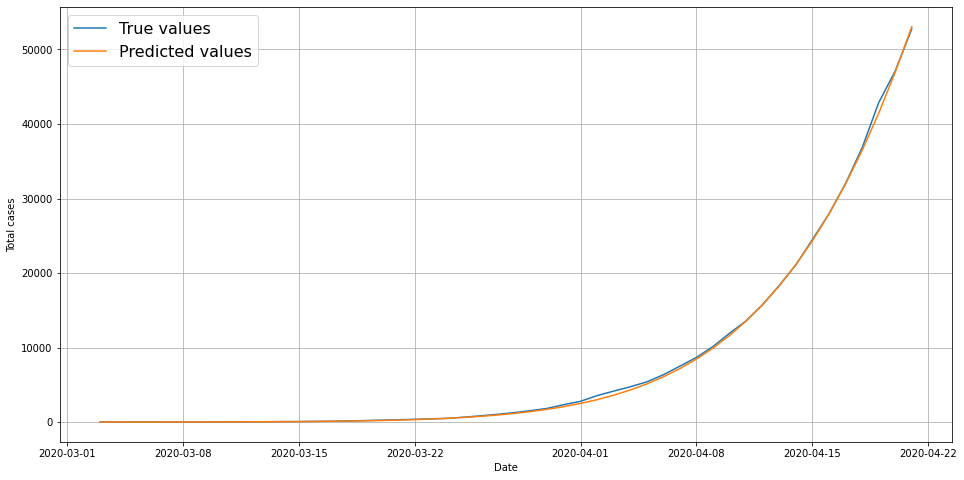

In [137]:
prediction = model.predict(x)

plt.figure(figsize=figsize)
plt.plot(
    rus_train["date"],
    rus_train["total_cases"],
    label="True values"
)
plt.plot(
    rus_train["date"],
    np.exp(prediction).cumsum(),
    label="Predicted values"
)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize)

In [138]:
sigma_noise = np.mean((y - prediction) ** 2)

In [139]:
x = np.column_stack([np.ones_like(rus_train["day"]), x])

mu, sigma = bayesian_update(
    np.zeros(3),
    1000 * np.eye(3),
    x,
    y,
    sigma_noise
)

In [140]:
print(f"W mean:\n{mu}")
print(f"W variance:\n{sigma}")

W mean:
[-0.39658641  0.2756225  -0.00182979]
W variance:
[[ 9.52394107e-03 -7.69480531e-04  1.29542176e-05]
 [-7.69480531e-04  8.48437326e-05 -1.61928267e-06]
 [ 1.29542176e-05 -1.61928267e-06  3.30466208e-08]]


In [141]:
# 2.3c

In [142]:
n_samples = 1000
w = np.random.multivariate_normal(mu, sigma, n_samples)

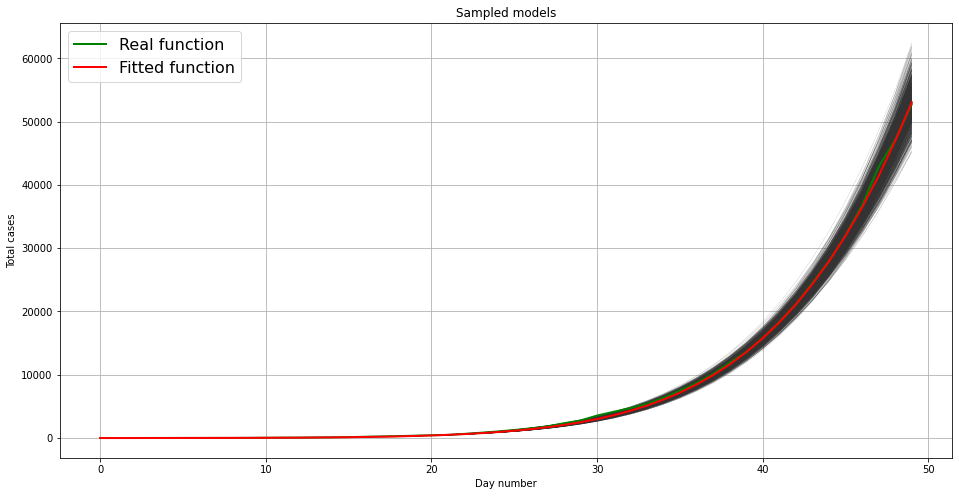

In [143]:
plt.figure(figsize=figsize)
plt.title("Sampled models")
for i in range(n_samples):
    plt.plot(rus_train["day"], np.exp(x.dot(w[i])).cumsum(),
             color="0.2", linewidth=.1)
plt.plot(rus_train["day"], rus_train["total_cases"],
         label="Real function", color="g", linewidth=2)
plt.plot(rus_train["day"], np.exp(prediction).cumsum(),
         label="Fitted function", color="r", linewidth=2)
plt.grid(True)
plt.xlabel("Day number")
plt.ylabel("Total cases")
plt.legend(fontsize=legend_fontsize)

In [144]:
x = np.arange(SEPTEMBER_FIRST + 1)

x_matrix = np.column_stack([np.ones(x.shape[0]), x, x ** 2])

prediction = np.exp(w.dot(x_matrix.T)).cumsum(1)

Text(0.5, 1.0, 'May 1 prediction distribution')

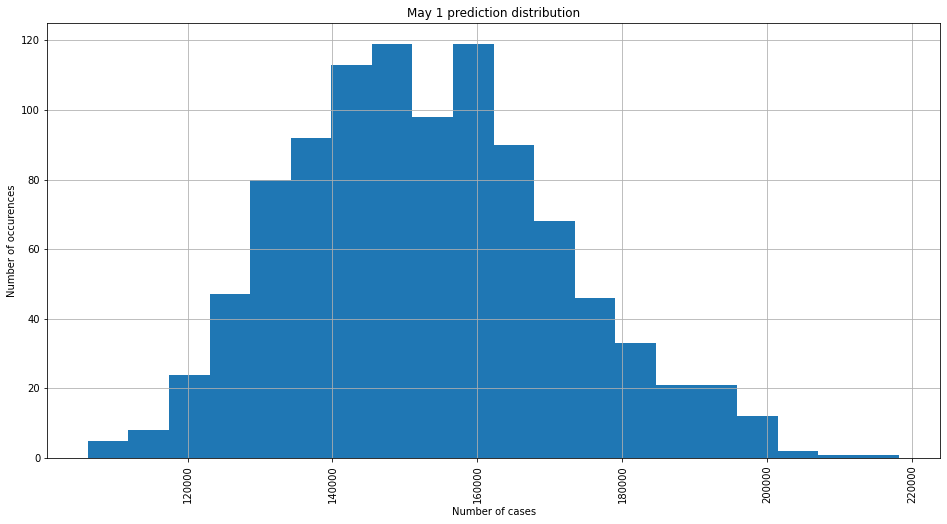

In [145]:
plt.figure(figsize=figsize)
plt.hist(prediction[:, MAY_FIRST], bins=20)
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("May 1 prediction distribution")

In [146]:
# Prediction for May 1
print(f"Median:\t\t{round(np.quantile(prediction[:, MAY_FIRST], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(prediction[:, MAY_FIRST], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(prediction[:, MAY_FIRST], 0.9))}")
print(f"True value:\t" \
      f"{rus_test[rus_test['day'] == MAY_FIRST]['total_cases'].iloc[0]}")

Median:		151508
10-quantile:	130434
90-quantile:	178237
True value:	114431


Text(0.5, 1.0, 'June 1 prediction distribution')

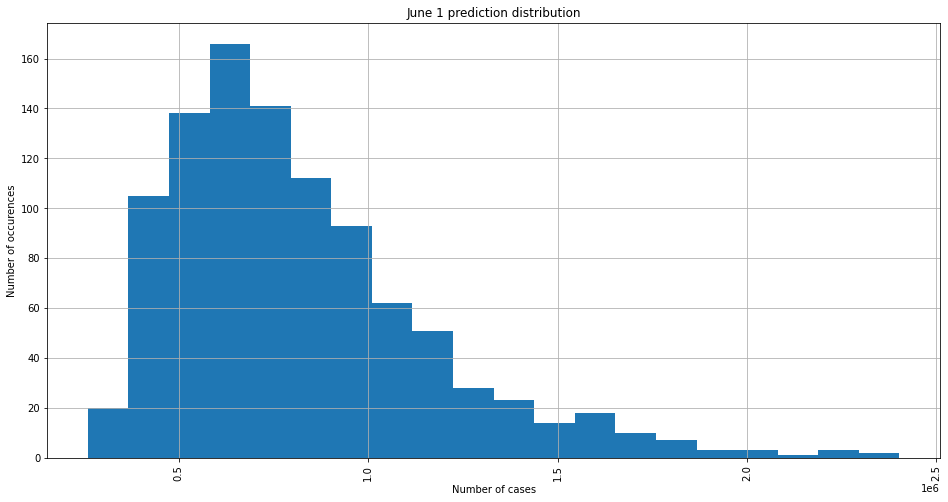

In [147]:
plt.figure(figsize=figsize)
plt.hist(prediction[:, JUNE_FIRST], bins=20)
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("June 1 prediction distribution")

In [148]:
# Prediction for June 1
print(f"Median:\t\t{round(np.quantile(prediction[:, JUNE_FIRST], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(prediction[:, JUNE_FIRST], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(prediction[:, JUNE_FIRST], 0.9))}")
print(f"True value:\t" \
      f"{rus_test[rus_test['day'] == JUNE_FIRST]['total_cases'].iloc[0]}")

Median:		743144
10-quantile:	452753
90-quantile:	1253119
True value:	414328


Text(0.5, 1.0, 'September 1 prediction distribution')

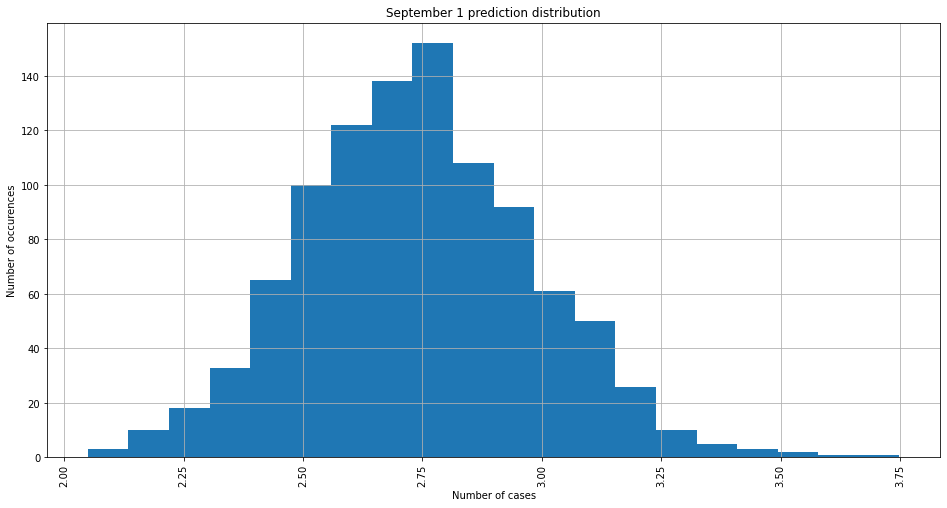

In [149]:
plt.figure(figsize=figsize)
plt.hist(prediction[:, 2], bins=20)
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("September 1 prediction distribution")

In [150]:
# Prediction for September 1
print(f"Median:\t\t{round(np.quantile(prediction[:, SEPTEMBER_FIRST], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(prediction[:, SEPTEMBER_FIRST], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(prediction[:, SEPTEMBER_FIRST], 0.9))}")
print(f"True value:\t" \
      f"{rus_test[rus_test['day'] == \
                     SEPTEMBER_FIRST]['total_cases'].iloc[0]}")

Median:		911018
10-quantile:	492947
90-quantile:	1871138
True value:	997072
